In [28]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import decomposition, ensemble

import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [29]:
# Load and view data

init_data = pd.read_csv("winemag-data_first150k.csv")
print("Length of initially loaded:", len(init_data))
init_data.head()

Length of initially loaded: 150930


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [30]:
# Drop Duplicates and NaNs (nulls)

parsed_data = init_data[init_data.duplicated('description', keep=False)]
print("Length of dataframe after duplicates are removed:", len(parsed_data))

parsed_data.dropna(subset=['description', 'points'])
print("Length of dataframe after NaNs are removed:", len(parsed_data))

parsed_data.head()

Length of dataframe after duplicates are removed: 92393
Length of dataframe after NaNs are removed: 92393


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
25,25,New Zealand,"Yields were down in 2015, but intensity is up,...",Maté's Vineyard,94,57.0,Kumeu,NaN,NaN,Chardonnay,Kumeu River
29,29,US,This standout Rocks District wine brings earth...,The Funk Estate,94,60.0,Washington,Walla Walla Valley (WA),Columbia Valley,Syrah,Saviah
60,60,Argentina,"Concentrated, ripe blackberry and cassis aroma...",The Apple Doesn't Fall Far From The Tree,91,30.0,Mendoza Province,Mendoza,NaN,Malbec,Matias Riccitelli
61,61,Australia,Moorooduc's estate Pinot Noir is a solid value...,NaN,91,36.0,Victoria,Mornington Peninsula,NaN,Pinot Noir,Moorooduc
62,62,Argentina,Smoky aromas of fresh-cut wood blend with berr...,Alegoría Gran Reserva,91,25.0,Mendoza Province,Mendoza,NaN,Malbec,Navarro Correas


In [31]:
# Create a data frame of just descriptions and points for analysis

dp = parsed_data[['description','points']]
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92393 entries, 25 to 150929
Data columns (total 2 columns):
description    92393 non-null object
points         92393 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.1+ MB


,description,points
25,"Yields were down in 2015, but intensity is up,...",94
29,This standout Rocks District wine brings earth...,94
60,"Concentrated, ripe blackberry and cassis aroma...",91
61,Moorooduc's estate Pinot Noir is a solid value...,91
62,Smoky aromas of fresh-cut wood blend with berr...,91


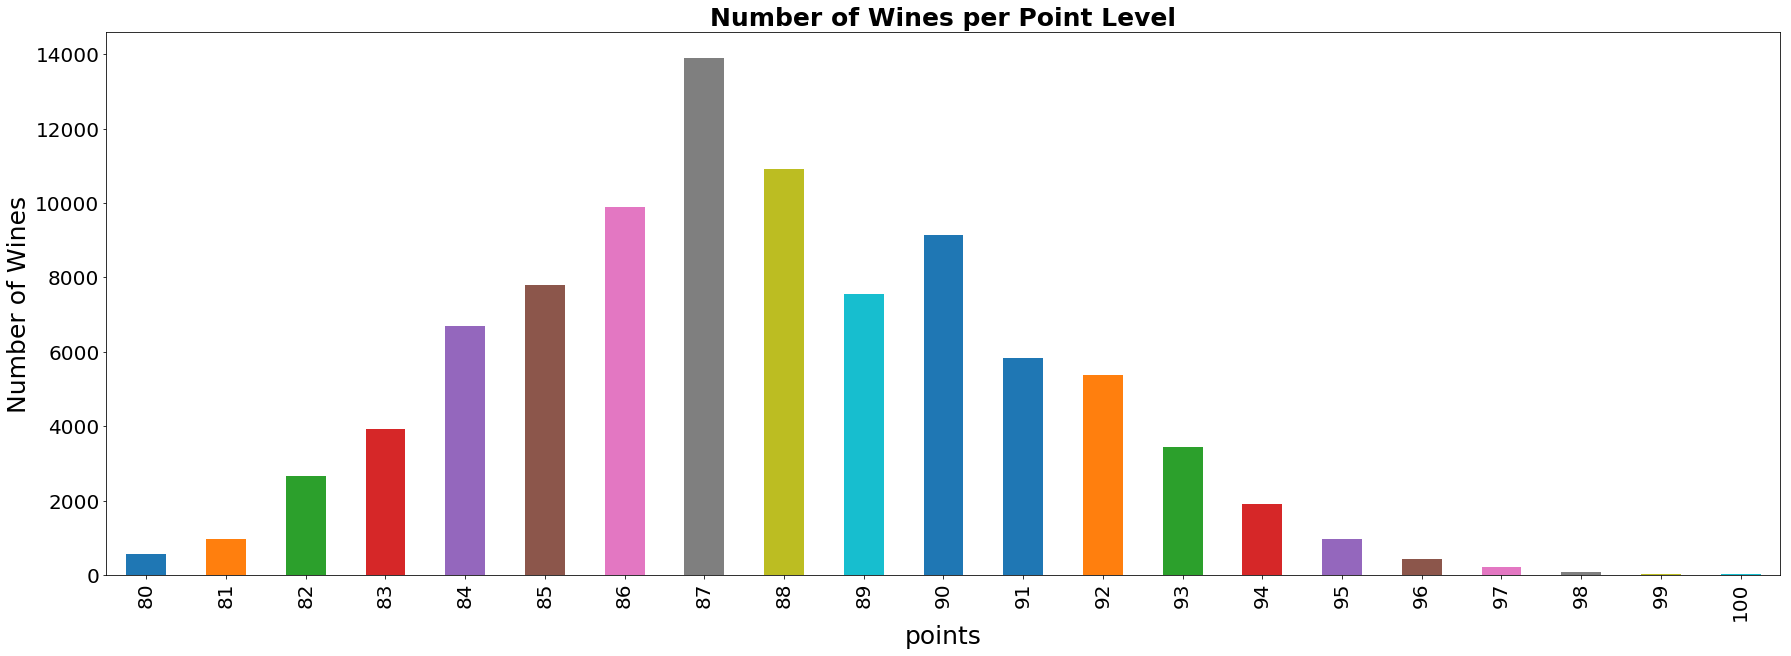

In [32]:
# What is the distribution of wines by points

fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of Wines per Point Level', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of Wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
dp.groupby(['points']).count()['description'].plot(ax=ax, kind='bar')

In [33]:
# What's the average point value:
dp['points'].mean()

87.7463877133549

In [34]:
# See above - higher point wines are rare: matches the market. Most wines converge around mean

# Let's now take a look at lenght of descriptions by points (add column to DP):

dp = dp.assign(description_length = dp['description'].apply(len))
dp.info()
dp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92393 entries, 25 to 150929
Data columns (total 3 columns):
description           92393 non-null object
points                92393 non-null int64
description_length    92393 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.8+ MB


,description,points,description_length
25,"Yields were down in 2015, but intensity is up,...",94,215
29,This standout Rocks District wine brings earth...,94,333
60,"Concentrated, ripe blackberry and cassis aroma...",91,242
61,Moorooduc's estate Pinot Noir is a solid value...,91,315
62,Smoky aromas of fresh-cut wood blend with berr...,91,229


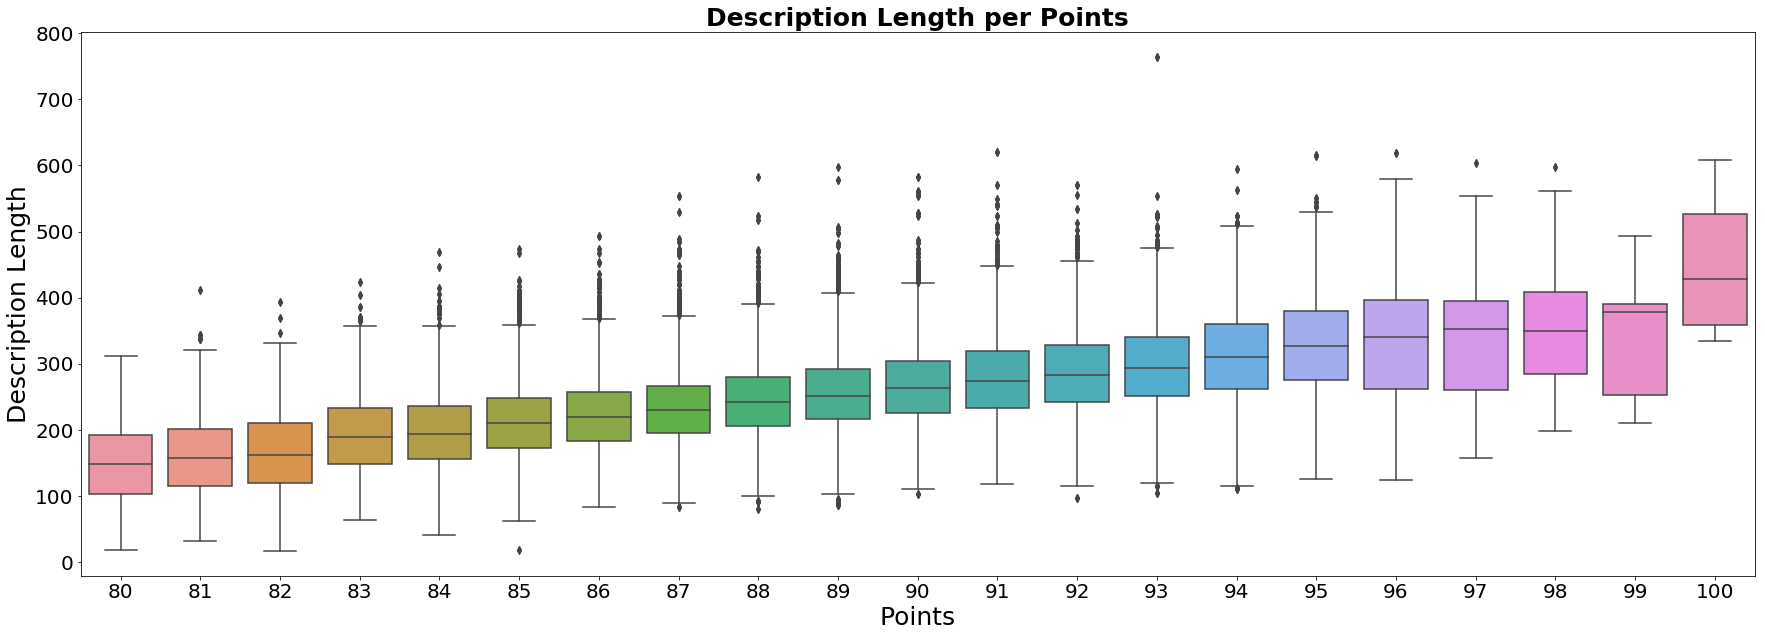

In [35]:
# Let's see if there is a pattern between points of wine and length of descriptions

fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points', y='description_length', data=dp)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

#### Simplifying the model
Having too many different possibility for "points" burdens models. A 90 points wine is not that different from a 91 points wine, the description is probably not that different also.

Let's try to simplify the model with 5 different values:

1 -> Points 80 to 84 (Under Average wines)

2 -> Points 84 to 88 (Average wines)

3 -> Points 88 to 92 (Good wines)

4 -> Points 92 to 96 (Very Good wines)

5 -> Points 96 to 100 (Excellent wines)

In [36]:
# Transform points into quintiles
def transform_points_simplified(points):
    if points < 84:
        return 1
    elif points >= 84 and points < 88:
        return 2 
    elif points >= 88 and points < 92:
        return 3 
    elif points >= 92 and points < 96:
        return 4 
    else:
        return 5

# Applying method and assigning result to new column "points_simplified" - will do this and will also try modeling without
dp_quint = dp.assign(points_simplified = dp['points'].apply(transform_points_simplified))
dp_quint.head()

,description,points,description_length,points_simplified
25,"Yields were down in 2015, but intensity is up,...",94,215,4
29,This standout Rocks District wine brings earth...,94,333,4
60,"Concentrated, ripe blackberry and cassis aroma...",91,242,3
61,Moorooduc's estate Pinot Noir is a solid value...,91,315,3
62,Smoky aromas of fresh-cut wood blend with berr...,91,229,3


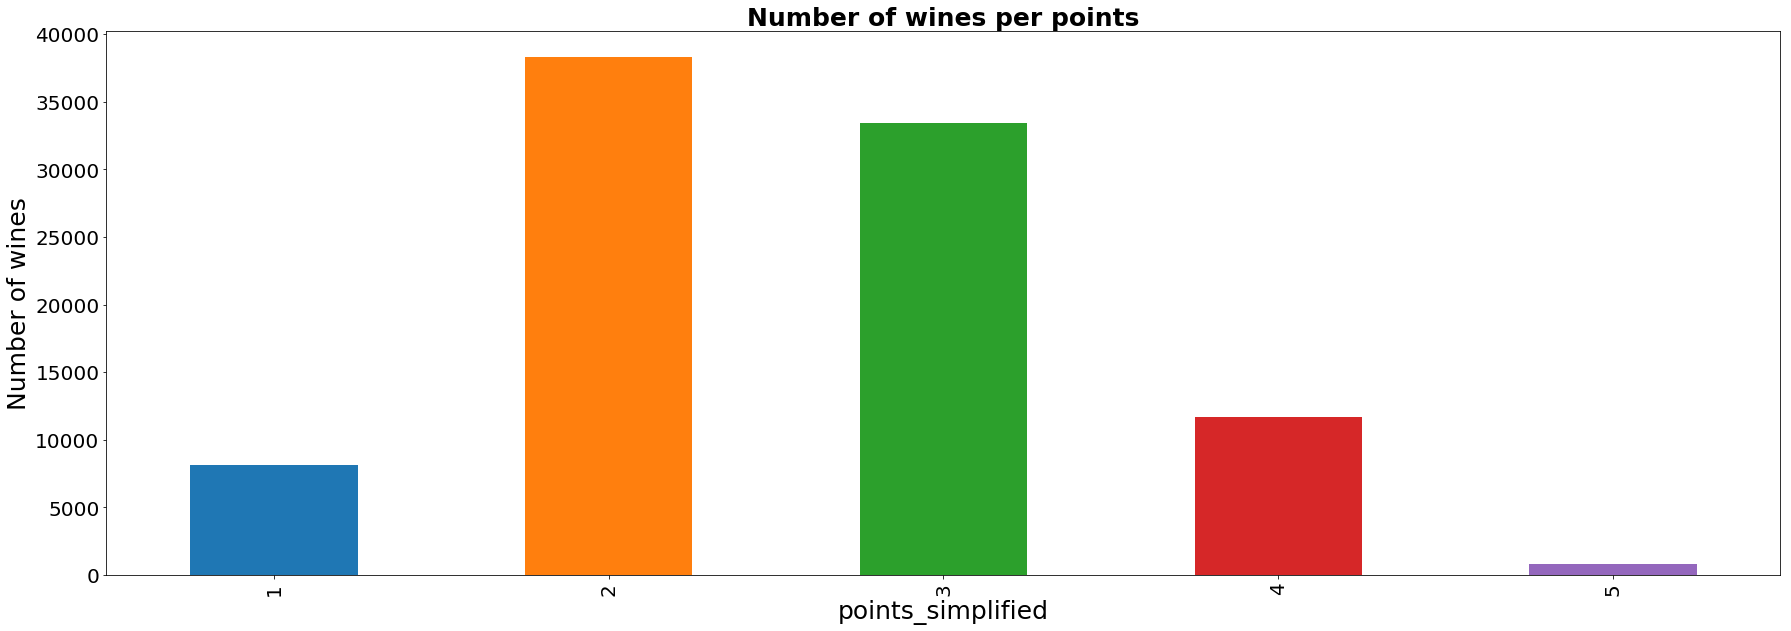

In [37]:
# Check distribution of our simplified buckets

fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of wines per points', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of wines', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
dp_quint.groupby(['points_simplified']).count()['description'].plot(ax=ax, kind='bar')

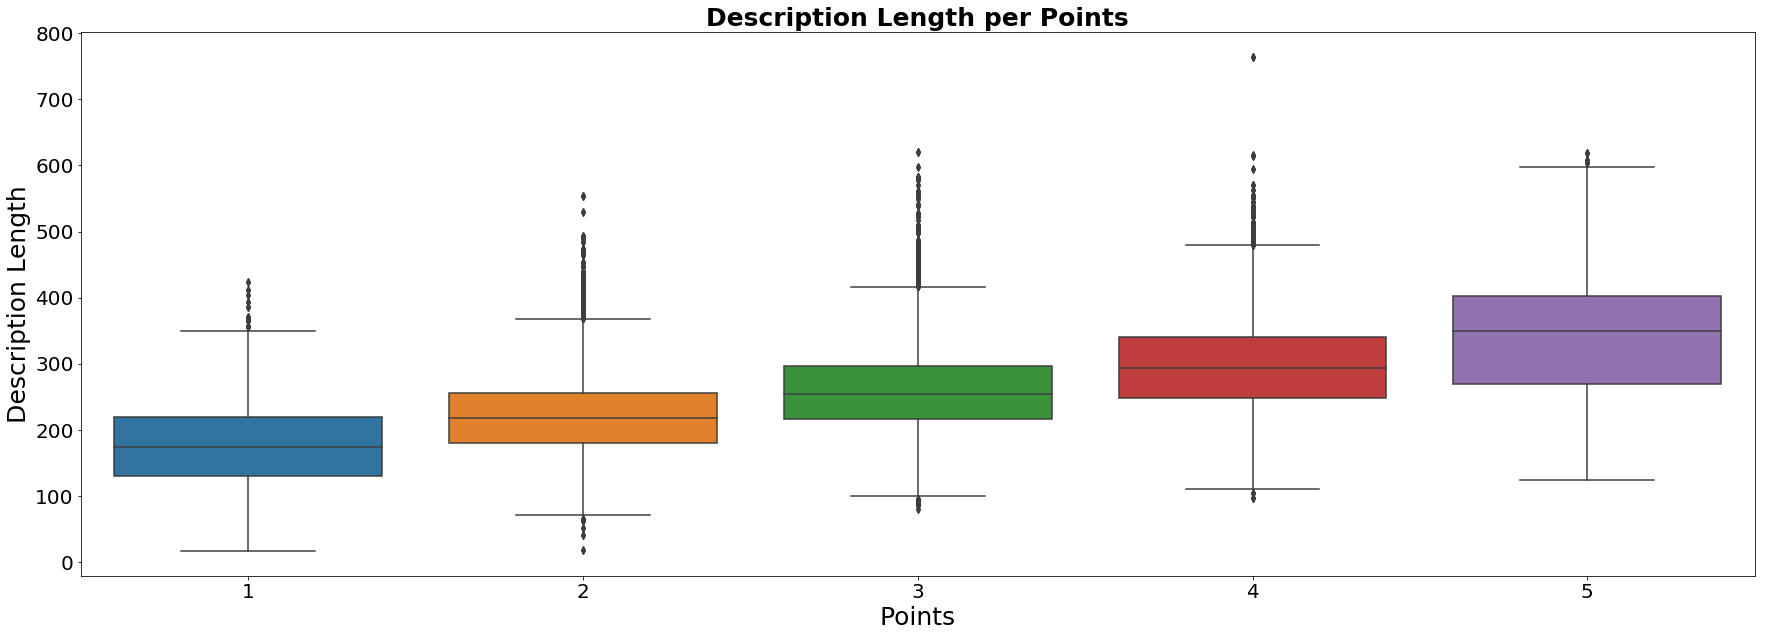

In [38]:
# Description lengths for the same:

fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(x='points_simplified', y='description_length', data=dp_quint)
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Description Length per Points', fontweight="bold", size=25) # Title
ax.set_ylabel('Description Length', fontsize = 25) # Y label
ax.set_xlabel('Points', fontsize = 25) # X label
plt.show()

In [39]:
# Vectorizing data

Xdpq = dp_quint['description']
ydpq = dp_quint['points_simplified']

vectorizer = CountVectorizer()
vectorizer.fit(Xdpq)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [40]:
Xdpq = vectorizer.transform(Xdpq)
print('Shape of Sparse Matrix: ', Xdpq.shape)
print('Amount of Non-Zero occurrences: ', Xdpq.nnz)
# Percentage of non-zero values
density = (100.0 * Xdpq.nnz / (Xdpq.shape[0] * Xdpq.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (92393, 21400)
Amount of Non-Zero occurrences:  3172240
Density: 0.1604402000353832


In [41]:
# Training -> 90% training and 10% testing

start = time.time() # TRACK TIME

# Training the model
Xdpq_train, Xdpq_test, ydpq_train, ydpq_test = train_test_split(Xdpq, ydpq, test_size=0.1, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(Xdpq_train, ydpq_train)

# Testing the model
preds_dpq = rfc.predict(Xdpq_test)
print(classification_report(ydpq_test, preds_dpq))

end = time.time()
final_time = round((end-start),0)
print(str(final_time) + " seconds")

             precision    recall  f1-score   support

          1       0.99      0.95      0.97       763
          2       0.95      0.98      0.97      3830
          3       0.97      0.96      0.96      3418
          4       1.00      0.94      0.97      1135
          5       1.00      0.94      0.97        94

avg / total       0.97      0.97      0.97      9240

23.0 seconds


In [42]:
# Precision and recall at 97% with count vectorization. Count vectorization simply \
# counts the words. TFIDF vectorizer we'll also try since it adjust for proportionality

# TF-IDF
Xdpq_tf = dp_quint['description']
ydpq_tf = dp_quint['points_simplified']

# Vectorizing model
vect_tf = TfidfVectorizer()
vect_tf.fit(Xdpq_tf)
Xdpq_tf = vect_tf.transform(Xdpq_tf)

In [43]:
# Training model

start_time = time.time()

Xdpq_tf_train, Xdpq_tf_test, ydpq_tf_train, ydpq_tf_test = train_test_split(Xdpq_tf, ydpq_tf, test_size=0.1, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(Xdpq_tf_train, ydpq_tf_train)

# Testing model
preds_dpq_tf = rfc.predict(Xdpq_tf_test)
print(classification_report(ydpq_tf_test, preds_dpq_tf))

end_time = time.time()
final_time = round((end_time-start_time),0)
print(str(final_time) + " seconds")

             precision    recall  f1-score   support

          1       0.98      0.94      0.96       763
          2       0.96      0.98      0.97      3830
          3       0.96      0.96      0.96      3418
          4       0.99      0.94      0.96      1135
          5       1.00      0.91      0.96        94

avg / total       0.97      0.97      0.97      9240

20.0 seconds


In [44]:
# Multinomial Naive Bayes - count vectors

start_time = time.time()

nb = naive_bayes.MultinomialNB()
nb.fit(Xdpq_train, ydpq_train)

preds_nb = nb.predict(Xdpq_test)
print(classification_report(ydpq_test,preds_nb))

end_time = time.time()
final_time = round((end_time-start_time),0)
print(str(final_time) + " seconds to run")

             precision    recall  f1-score   support

          1       0.66      0.67      0.66       763
          2       0.75      0.75      0.75      3830
          3       0.71      0.65      0.68      3418
          4       0.55      0.72      0.63      1135
          5       0.70      0.07      0.13        94

avg / total       0.70      0.70      0.70      9240

0.0 seconds to run


In [45]:
# Multinomial Naive Bayes - tfidf
nb_tf = naive_bayes.MultinomialNB()
nb_tf.fit(Xdpq_tf_train,ydpq_tf_train)

preds_nb_tf = nb_tf.predict(Xdpq_tf_test)
print(classification_report(ydpq_tf_test,preds_nb_tf))

             precision    recall  f1-score   support

          1       1.00      0.14      0.25       763
          2       0.67      0.86      0.76      3830
          3       0.64      0.73      0.68      3418
          4       0.80      0.19      0.31      1135
          5       0.00      0.00      0.00        94

avg / total       0.70      0.67      0.62      9240



/Users/nathanielhoffelmeyer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
# Logistic Regression count vector

start = time.time()

lm = linear_model.LogisticRegression()
lm.fit(Xdpq_train, ydpq_train)

preds_lm = lm.predict(Xdpq_test)
print(classification_report(ydpq_test,preds_lm))

end = time.time()
final = round((end-start),0)
print(str(final) + " seconds to run")

             precision    recall  f1-score   support

          1       0.89      0.73      0.80       763
          2       0.80      0.87      0.83      3830
          3       0.79      0.78      0.78      3418
          4       0.83      0.73      0.78      1135
          5       1.00      0.70      0.82        94

avg / total       0.81      0.81      0.81      9240

39.0 seconds to run


In [47]:
# Logistic Regression tfidf

start = time.time()

lm.fit(Xdpq_tf_train, ydpq_tf_train)

preds_lmtf = lm.predict(Xdpq_tf_test)
print(classification_report(ydpq_tf_test,preds_lmtf))

end = time.time()
final = round((end-start),0)
print(str(final) + " seconds to run")

             precision    recall  f1-score   support

          1       0.88      0.55      0.68       763
          2       0.74      0.85      0.79      3830
          3       0.71      0.73      0.72      3418
          4       0.75      0.53      0.62      1135
          5       1.00      0.13      0.23        94

avg / total       0.74      0.73      0.73      9240

7.0 seconds to run


#### Next we want to look at whether or not we can also predict type of wine from a description (red or white).

In [48]:
# Create a data frame of just descriptions and variety for analysis

dt = parsed_data[['description', 'variety']]
dt.info()
dt.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92393 entries, 25 to 150929
Data columns (total 2 columns):
description    92393 non-null object
variety        92393 non-null object
dtypes: object(2)
memory usage: 2.1+ MB


,description,variety
25,"Yields were down in 2015, but intensity is up,...",Chardonnay
29,This standout Rocks District wine brings earth...,Syrah
60,"Concentrated, ripe blackberry and cassis aroma...",Malbec
61,Moorooduc's estate Pinot Noir is a solid value...,Pinot Noir
62,Smoky aromas of fresh-cut wood blend with berr...,Malbec


In [49]:
# Count how many unique variety there are, and how many each review has
print(dt['variety'].nunique())
udt = dt.groupby('variety')['description'].nunique() # unique variety with count of reviews
udt

456


variety
Agiorgitiko               38
Aglianico                 44
Airen                      2
Albana                     2
Albariño                 129
Aleatico                   4
Alfrocheiro                5
Alicante                   2
Alicante Bouschet          8
Aligoté                    8
Alsace white blend         7
Alvarelhão                 1
Alvarinho                 12
Angevine                   2
Ansonica                   1
Antão Vaz                  3
Apple                      3
Aragonez                   1
Aragonês                   3
Argaman                    1
Arinto                    18
Arneis                    20
Assyrtico                 18
Assyrtiko                  1
Athiri                     1
Austrian Red Blend        23
Austrian white blend       9
Auxerrois                  1
Baco Noir                  1
Baga                       6
                        ... 
Verduzzo Friulano          3
Vermentino                62
Vermentino Nero            1
Vernac

We have too many varietals to depict a nice graph, so let's add country. Then we can group by country and varietal and get a sense of the distribution of the overall data that way.

In [50]:
# Create a data frame of descrition, variety, and country

dvc = parsed_data[['description','variety', 'country']]
dvc.info()
dvc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92393 entries, 25 to 150929
Data columns (total 3 columns):
description    92393 non-null object
variety        92393 non-null object
country        92390 non-null object
dtypes: object(3)
memory usage: 2.8+ MB


,description,variety,country
25,"Yields were down in 2015, but intensity is up,...",Chardonnay,New Zealand
29,This standout Rocks District wine brings earth...,Syrah,US
60,"Concentrated, ripe blackberry and cassis aroma...",Malbec,Argentina
61,Moorooduc's estate Pinot Noir is a solid value...,Pinot Noir,Australia
62,Smoky aromas of fresh-cut wood blend with berr...,Malbec,Argentina


In [51]:
# How many unique countries are in our dataset?
print(dvc['country'].nunique())

41


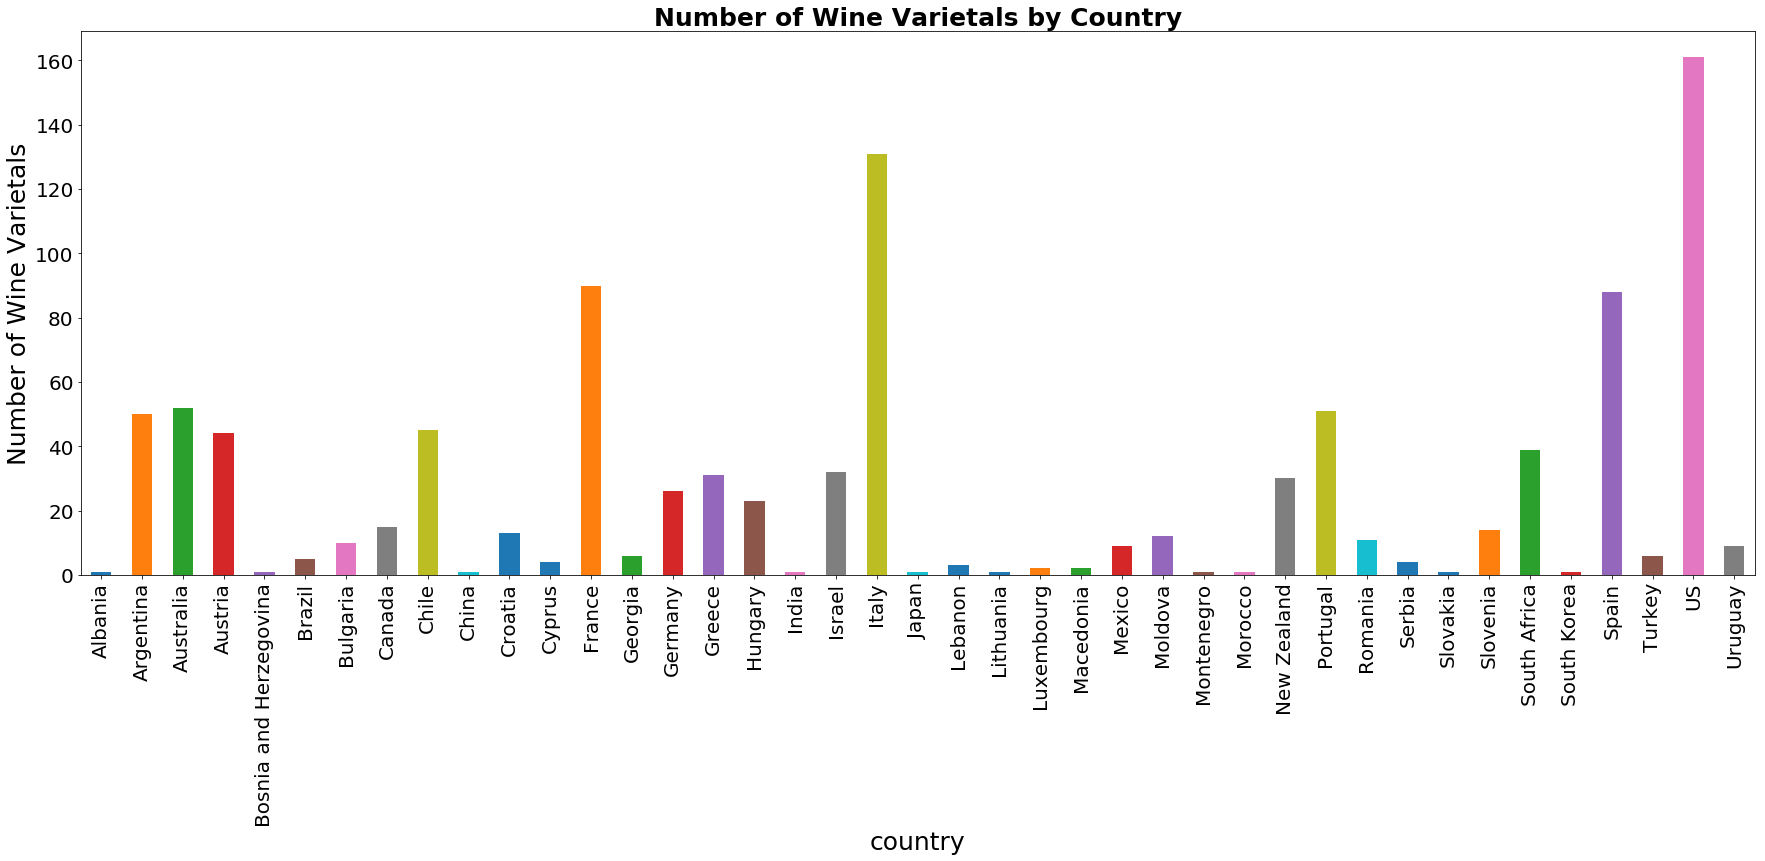

In [52]:
# What's the distribution of the wine varietals by country

# Check distribution of our simplified buckets

fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Number of Wine Varietals by Country', fontweight="bold", size=25) # Title
ax.set_ylabel('Number of Wine Varietals', fontsize = 25) # Y label
ax.set_xlabel('Country', fontsize = 25) # X label
dvc.groupby(['country']).nunique()['variety'].plot(ax=ax, kind='bar')

In [53]:
# Vectorizing data

Xvar = dt['description']
yvar = dt['variety']

vectorizer = CountVectorizer()
vectorizer.fit(Xvar)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [54]:
Xvar = vectorizer.transform(Xvar)
print('Shape of Sparse Matrix: ', Xvar.shape)
print('Amount of Non-Zero occurrences: ', Xvar.nnz)
# Percentage of non-zero values
density_var = (100.0 * Xvar.nnz / (Xvar.shape[0] * Xvar.shape[1]))
print('Density: {}'.format((density_var)))

Shape of Sparse Matrix:  (92393, 21400)
Amount of Non-Zero occurrences:  3172240
Density: 0.1604402000353832


In [55]:
# Training -> 90% training and 10% testing

# Training the model for count vectorizer
Xvar_train, Xvar_test, yvar_train, yvar_test = train_test_split(Xvar, yvar, test_size=0.1, random_state=101)
rfc = RandomForestClassifier()
rfc.fit(Xvar_train, yvar_train)

# Testing the model
preds_var = rfc.predict(Xvar_test)
print(classification_report(yvar_test, preds_var))

                                     precision    recall  f1-score   support

                        Agiorgitiko       0.80      1.00      0.89         8
                          Aglianico       1.00      1.00      1.00        13
                           Albariño       0.90      1.00      0.95        19
                           Aleatico       0.00      0.00      0.00         0
                        Alfrocheiro       1.00      1.00      1.00         1
                            Aligoté       1.00      1.00      1.00         2
                 Alsace white blend       1.00      1.00      1.00         2
                          Alvarinho       1.00      1.00      1.00         2
                          Antão Vaz       1.00      1.00      1.00         1
                              Apple       1.00      1.00      1.00         2
                           Aragonez       1.00      1.00      1.00         1
                            Argaman       1.00      1.00      1.00         

/Users/nathanielhoffelmeyer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nathanielhoffelmeyer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


**Our Random Forest Classifier has 96% precision and recall!**

In [56]:
# TF-IDF
Xvar_tf = dt['description']
yvar_tf = dt['variety']

# Vectorizing model
vect_var_tf = TfidfVectorizer()
vect_var_tf.fit(Xvar_tf)
Xvar_tf = vect_var_tf.transform(Xvar_tf)
print('Shape of Sparse Matrix: ', Xvar_tf.shape)
print('Amount of Non-Zero occurrences: ', Xvar_tf.nnz)
# Percentage of non-zero values
density_var_tf = (100.0 * Xvar_tf.nnz / (Xvar_tf.shape[0] * Xvar_tf.shape[1]))
print('Density: {}'.format((density_var_tf)))

Shape of Sparse Matrix:  (92393, 21400)
Amount of Non-Zero occurrences:  3172240
Density: 0.1604402000353832


In [57]:
# Training the model for tfidf
Xvar_tf_train, Xvar_tf_test, yvar_tf_train, yvar_tf_test = train_test_split(Xvar_tf, yvar_tf, test_size=0.1, random_state=101)
rfc.fit(Xvar_tf_train, yvar_tf_train)

# Testing the model
preds_var_tf = rfc.predict(Xvar_tf_test)
print(classification_report(yvar_tf_test, preds_var_tf))

                                     precision    recall  f1-score   support

                        Agiorgitiko       1.00      1.00      1.00         8
                          Aglianico       1.00      1.00      1.00        13
                           Albariño       0.90      1.00      0.95        19
                        Alfrocheiro       1.00      1.00      1.00         1
                            Aligoté       1.00      1.00      1.00         2
                 Alsace white blend       1.00      1.00      1.00         2
                          Alvarinho       1.00      1.00      1.00         2
                          Antão Vaz       1.00      1.00      1.00         1
                              Apple       1.00      1.00      1.00         2
                           Aragonez       1.00      1.00      1.00         1
                            Argaman       1.00      1.00      1.00         1
                             Arinto       1.00      1.00      1.00         

/Users/nathanielhoffelmeyer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
